# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
import numpy as np
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = np.shape(X_train)

# TODO: Number of testing examples.
n_test = np.shape(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train)[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = (39209, 32, 32, 3)
Number of testing examples = (12630, 32, 32, 3)
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

### Data exploration visualization.

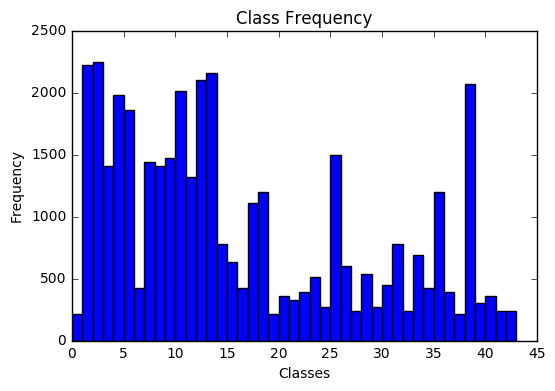

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# function to generate frequency of each class data
def class_frequency(labels):
    frequency = []
    for n in range(n_classes):
        frequency.append(np.shape(np.where(labels==n)[0])[0])
    return frequency

class_freq = class_frequency(y_train)

# plot a bar chat to show the frequency of each class in the dataset
index = np.arange(np.shape(class_freq)[0])
plt.bar(index, class_freq, 1)
plt.title('Class Frequency')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

In [5]:
import csv
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    class_names = dict(reader)

# choose one sample to use for visualization from each class
sample_class_image = []
for n in range(n_classes):
    sample_class_image.append(np.random.choice(np.where(y_train==n)[0]))

show_samples = X_train[sample_class_image,:,:,:]

In [6]:
## plot classes in a grid

# function to plot sample images in a grid
def plot_classes(box, grid_w, grid_h, stitch_layers=False):
    fig = plt.figure()
    for j in range(box.shape[0]):
        ax = fig.add_subplot(grid_h, grid_w, j+1)
        ax.imshow(box[j], cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()

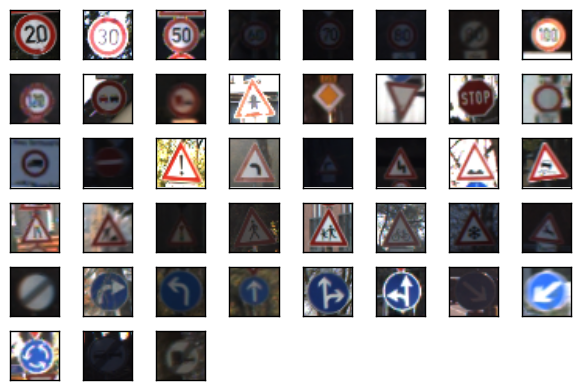

In [7]:
# display sample image in each class
plot_classes(show_samples, 8,6)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Preprocess data

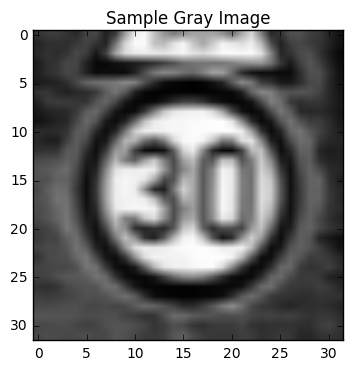

In [8]:
import cv2
from copy import deepcopy

# convert the the images to grayscale
X_train_gray = [cv2.cvtColor(X_train[n,:,:,:], cv2.COLOR_BGR2GRAY) 
                for n in range(np.shape(X_train)[0])]
X_test_gray = [cv2.cvtColor(X_test[n,:,:,:], cv2.COLOR_BGR2GRAY) 
                for n in range(np.shape(X_test)[0])]

# make a copy of labels
y_train_copy = deepcopy(y_train)

# show a sample image converted
plt.imshow(X_train_gray[1000], cmap='gray')
plt.title('Sample Gray Image')
plt.show()

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I converted the images which are originally in RGB format to grayscale images. I did this because I think the features needed for this kind of classification does not necessarily depend on the colours in the image. The characters in the traffic signs usually have the same colours or at most colours that dont really look different in grayscale.

I also plan to perform normalization to the images to allow for better initialization of the parameters of the network. This, I would do after generating additional dataset for training.

### Generate data additional data (OPTIONAL!)
#### perform some transformation on original dataset to create additional dataset for clasess with low frequencies

In [9]:
# trasformation 1
def trans_1(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,0],[32,5],[0,32],[32,27]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 2
def trans_2(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,5],[32,0],[0,27],[32,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 3
def trans_3(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[5,0],[27,0],[0,32],[32,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 4 - rotation +15
def trans_4(image):
    M = cv2.getRotationMatrix2D((16,16),15,1)
    dst = cv2.warpAffine(image,M,(32,32))
    return dst

# trasformation 5 - rotation -15
def trans_5(image):
    M = cv2.getRotationMatrix2D((16,16),-15,1)
    dst = cv2.warpAffine(image,M,(32,32))
    return dst

# transformation 6 - skew image 1
def trans_6(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,0],[27,5],[5,32],[32,27]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# transformation 7 - skew image 2
def trans_7(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[5,5],[32,0],[0,27],[27,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

Transformations for data augmentation:


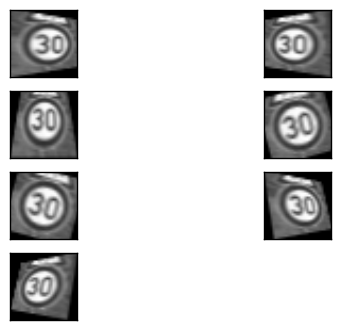

In [18]:
## visualize the transformations to be performed on the dataset
sample_im = X_train_gray[1000]

transformations = [trans_1, trans_2, trans_3, trans_4, trans_5, trans_6, trans_7]

for i, tr in enumerate(transformations):
    transformed = tr(sample_im)
    plt.subplot(4,2,i+1)
    plt.imshow(transformed, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

print('Transformations for data augmentation:')

In [9]:
# global variable to keep all dataset
all_X_train = deepcopy(X_train_gray)
all_y_train = deepcopy(y_train_copy)

In [10]:
## we use data augmentation to beef up classes that has low frequencies

# augment data function:
def augment_data(augment_fn, X_data,y_data):
    global all_X_train
    global all_y_train
   
    print('old shape:')
    print(np.shape(all_y_train))

    class_freq = class_frequency(all_y_train)

    mean_freq = int(np.average(class_freq))
    print('mean frequency:', mean_freq)

    transform_X = []
    transform_y = []
    for i, im in enumerate(X_data):
        if class_freq[y_data[i]] < mean_freq:
            im_trans = trans_1(im)
            transform_X.append(im)
            transform_y.append(y_data[i])

    all_X_train = np.append(all_X_train, transform_X, axis=0)
    all_y_train = np.append(all_y_train, transform_y, axis=0)

    print('new shape:')
    print(np.shape(all_X_train))
    print(np.shape(all_y_train))

    class_freq = class_frequency(all_y_train)
    display_image_id = 1000

    plt.figure(1)
    n = np.size(class_freq)

    index = np.arange(np.shape(class_freq)[0])
    plt.bar(index, class_freq, 1)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show

old shape:
(39209,)
mean frequency: 911
new shape:
(49708, 32, 32)
(49708,)


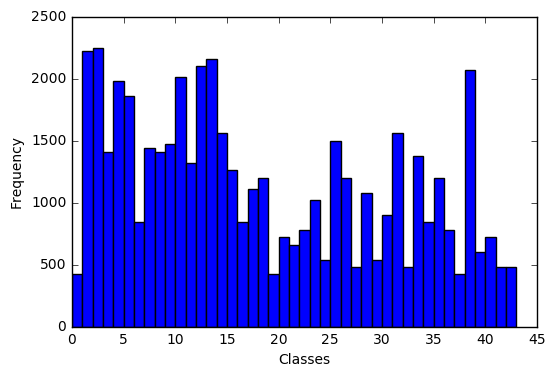

In [11]:
# augmentation 1
augment_data(trans_1, X_train_gray, y_train_copy)

old shape:
(49708,)
mean frequency: 1156
new shape:
(57838, 32, 32)
(57838,)


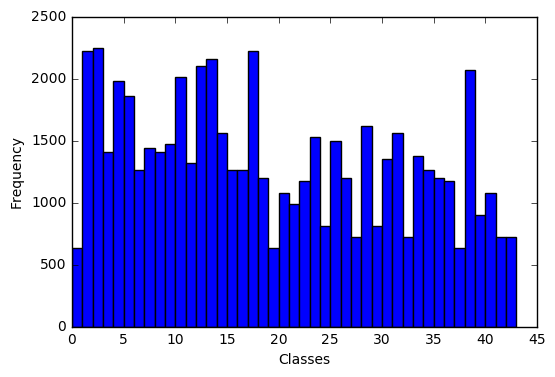

In [12]:
# augmentation 2
augment_data(trans_2, X_train_gray, y_train_copy)

old shape:
(57838,)
mean frequency: 1345
new shape:
(68308, 32, 32)
(68308,)


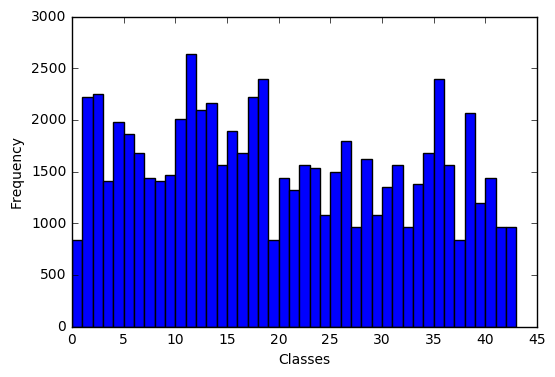

In [13]:
# augmentation 3
augment_data(trans_3, X_train_gray, y_train_copy)

old shape:
(68308,)
mean frequency: 1588
new shape:
(83007, 32, 32)
(83007,)


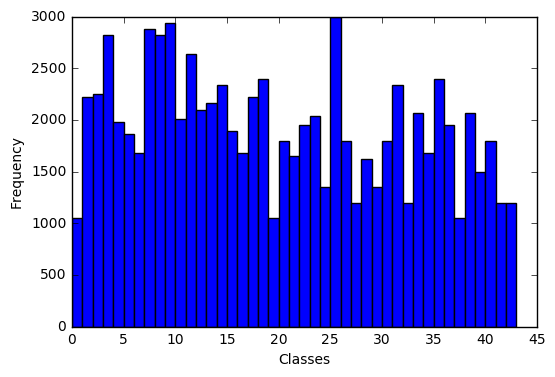

In [14]:
# augmentation 4
augment_data(trans_4, X_train_gray, y_train_copy)

old shape:
(83007,)
mean frequency: 1930
new shape:
(91827, 32, 32)
(91827,)


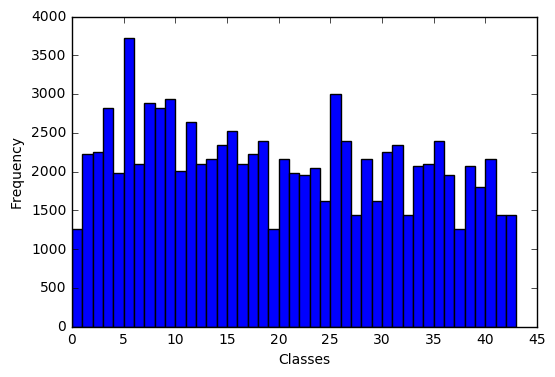

In [15]:
# augmentation 5
augment_data(trans_5, X_train_gray, y_train_copy)

old shape:
(91827,)
mean frequency: 2135
new shape:
(105986, 32, 32)
(105986,)


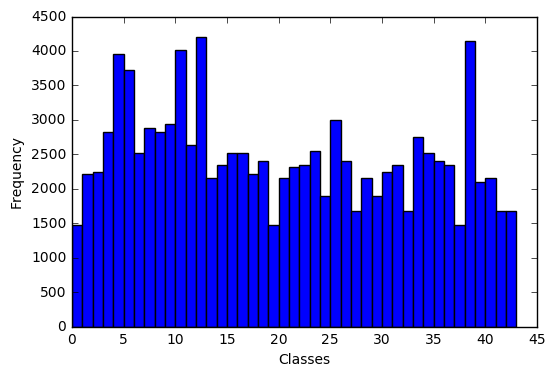

In [16]:
# augmentation 6
augment_data(trans_6, X_train_gray, y_train_copy)

old shape:
(105986,)
mean frequency: 2464
new shape:
(123536, 32, 32)
(123536,)


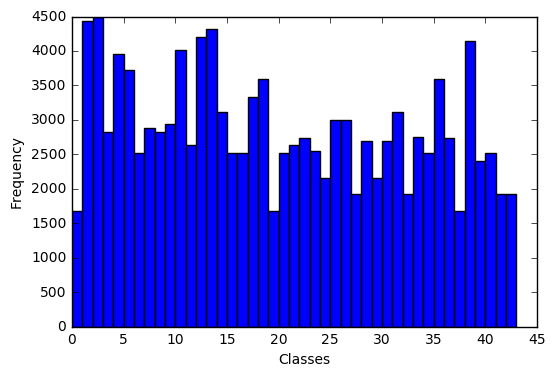

In [17]:
# augmentation 7
augment_data(trans_7, X_train_gray, y_train_copy)

### Split the data into training/validation/testing sets.


In [18]:
frequency = []

new_X_train = []
new_y_train = []

new_X_val = []
new_y_val = []

for n in range(n_classes):
    # find indexes of a classes in the dataset
    # randomly choose from and make up a validation set for each class
    where_id = np.where(all_y_train==n)[0]
    np.random.shuffle(where_id)
    
    new_X_train.append(all_X_train[where_id][:int(np.shape(where_id)[0]*0.8)])
    new_X_val.append(all_X_train[where_id][int(np.shape(where_id)[0]*0.8):])
    
    new_y_train.append(all_y_train[where_id][:int(np.shape(where_id)[0]*0.8)])
    new_y_val.append(all_y_train[where_id][int(np.shape(where_id)[0]*0.8):])
else:
    # stack up training and validation sets
    new_X_train = np.vstack(new_X_train)
    new_X_val = np.vstack(new_X_val)
    new_y_train = np.hstack(new_y_train)
    new_y_val = np.hstack(new_y_val)

In [19]:
# confirm shape of datasets made
print('shape of train data',np.shape(new_X_train))
print('shape of validation data', np.shape(new_X_val))


shape of train data (98828, 32, 32)
shape of validation data (24708, 32, 32)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I set up validation set by choosing a random 20% of the data from each class. This will ensure the each class is proportionately represented in the validation set since some classes have more data than the other.

***about addtional data generated:***

Additional data was generated to make classification perspective and skew invariant since sign classifier will not only be applied on images whose plane are parallel to the plane of the camera. Images will mostly appear skewed or 'perspective-transformed' in real life applications.
This was done by applying 3 perspective transformations, 2 skew transformations and 2 rotations at +15deg and -15deg.

### Definition of architecture

In [20]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

keep_prob = tf.placeholder(tf.float32)

def signs_classify(x, keep_prob):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation 1.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation 2.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 800. Output = 516.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 516), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(516))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation 3.
    fc1    = tf.nn.relu(fc1)
    
    # dropout 1
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 516. Output = 360.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(516, 360), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(360))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation 4.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 360. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(360, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits    

In [21]:
# prepare features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)

l_rate = 0.001

logits = signs_classify(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = l_rate)
training_operation = optimizer.minimize(loss_operation)

In [22]:
# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, drop_prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: drop_prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

***Architecture:***

Layer 1: Convolution of 5x5 kernel, 1 stride and 6 feature maps
Activation: ReLU
Pooling 1: 2x2 kernel and 2 stride

Layer 2: Convolution of 5x5 kernel, 1 stride and 16 feature maps
Activation: ReLU
Pooling 2: 2x2 kernel and 2 stride

Layer 3: Fully connected layer with 516 units
Activation: ReLU

Layer 4: Fully connected layer with 360 units
Activation: ReLU

Layer 5: Fully connected layer with 43 units for logits(network) output
Activation: Softmax

I arrived at the values in the fully connected layers by scaling the LeNet model to 43 classes.

### Train model

In [23]:
new_X_train = np.reshape(new_X_train, (np.shape(new_X_train)[0],32,32,1))
new_X_val = np.reshape(new_X_val, (np.shape(new_X_val)[0],32,32,1))

# normalize dataset [naive]
new_X_train = (np.array(new_X_train) - 128.0)/256.0
new_X_val = (np.array(new_X_val) - 128.0)/256.0

In [24]:
from sklearn.utils import shuffle

save_file = 'sign_classify.ckpt'
EPOCHS = 15
BATCH_SIZE = 128
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(new_X_train, new_y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.25})
            
        validation_accuracy = evaluate(new_X_val, new_y_val, drop_prob=1.0)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.682

EPOCH 2 ...
Validation Accuracy = 0.890

EPOCH 3 ...
Validation Accuracy = 0.956

EPOCH 4 ...
Validation Accuracy = 0.970

EPOCH 5 ...
Validation Accuracy = 0.981

EPOCH 6 ...
Validation Accuracy = 0.982

EPOCH 7 ...
Validation Accuracy = 0.988

EPOCH 8 ...
Validation Accuracy = 0.990

EPOCH 9 ...
Validation Accuracy = 0.991

EPOCH 10 ...
Validation Accuracy = 0.991

EPOCH 11 ...
Validation Accuracy = 0.995

EPOCH 12 ...
Validation Accuracy = 0.994

EPOCH 13 ...
Validation Accuracy = 0.995

EPOCH 14 ...
Validation Accuracy = 0.995

EPOCH 15 ...
Validation Accuracy = 0.996

Model saved


### Test Model

In [25]:
new_X_test = np.reshape(X_test_gray, (np.shape(X_test_gray)[0],32,32,1))

# normalize dataset [naive]
new_X_test = (np.array(new_X_test) - 128.0)/256.0

drop_prob = 1.0

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign_classify.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    test_accuracy = sess.run(
        accuracy_operation,
        feed_dict={x: batch_x, y: batch_y, keep_prob: drop_prob})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9921875


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the following in training the model

Optimizer: Adam optimizer with learning rate of 0.001

Batch size: 128

Epochs: 10

Hyperparameters: Weight initialization with mean of 0 and standard deviation of 0.1, Dropout keep-probability of 0.5 for training and 1.0 for evaluation

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with the LeNet model and changed the parameters to suit classification problem after doing a couple of trial training.

The Adam optimizer works well since it is an adaptive method, which computes adaptive learning rates, so there is not much need to tune the optimizer parameters. However I noticed that increasing the learning rate gave a much worse result.

I trained with large number of epochs (>20) for early trial trainings but found that the validation accuracy grows above 0.99 while approaching 10 epochs and doesn't change much after 10 epochs, so I rationally chose 15 epochs to prevent overfitting of the model.

Without dropout, the model gets good validation accuracies but to prevent overfitting and get a better test accuracy, I used dropout keep-probability of 0.25 for training and 1.0 during validation.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Prediction: 1 	| Speed limit (30km/h)
Prediction: 6 	| End of speed limit (80km/h)
Prediction: 14 	| Stop
Prediction: 16 	| Vehicles over 3.5 metric tons prohibited
Prediction: 1 	| Speed limit (30km/h)
Prediction: 28 	| Children crossing
Prediction: 4 	| Speed limit (70km/h)
Prediction: 0 	| Speed limit (20km/h)
Prediction: 13 	| Yield
Prediction: 12 	| Priority road
Prediction: 17 	| No entry
Prediction: 18 	| General caution
Prediction: 42 	| End of no passing by vehicles over 3.5 metric tons
Prediction: 12 	| Priority road
Prediction: 40 	| Roundabout mandatory
Prediction: 15 	| No vehicles


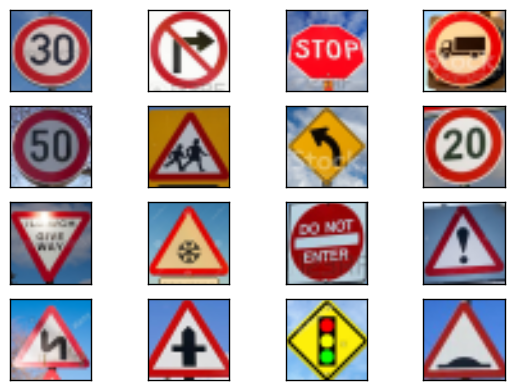

In [26]:
### Load the images and plot them here.
# we have 16 images to test, saved in the same directory
no_of_imgs = 16
disp_imgs = []
disp_imgs_gray = []
for n in range(no_of_imgs):
    image = cv2.imread('model_test_images/'+str(n+1)+'.jpg')
    dim = (32,32)

    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    resized = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)
    
    disp_imgs.append(np.asarray(resized))
    
    resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
    disp_imgs_gray.append(np.asarray(resized))

plot_classes(np.array(disp_imgs), 4,4)

# normalize new test data
test_imgs_gray = ((np.array(disp_imgs_gray)-128.0)/256.0).reshape(no_of_imgs,32,32,1)

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign_classify.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    prediction = tf.argmax(logits, 1)

    test_prediction = sess.run(
        prediction,
        feed_dict={x: test_imgs_gray, keep_prob: drop_prob})
for i in range(no_of_imgs):
    print('Prediction: {} \t| {}'.format(test_prediction[i], 
                                            class_names[str(test_prediction[i])]))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

From the results I got from the test. I think the following could make a classification difficult:

1. When a class image has not been seen by the classifier (see image 5 in the cell below)
2. When images from different classes look similar (see image 2 in the cell below)
3. When there is marked difference between images learned and the new image to be classified. The model would be unsure about the prediction and/or make a wrong prediction

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Even though the model scored high on the test sets provided with the original dataset, it didn't perform so well with new, but similar images. With 16 new images gotten from the internet, the model had an accuracy of ***62.5%*** with new test images.
The model interestingly fails on images that are similar but have different outline shapes. The model seems to have learned more features about the outline of the shapes in the sign than the contents in the shapes.

### Visualize the softmax probabilities

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**

In [27]:
# get the softmax probabilities for 3 best prediction probabilities.
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign_classify.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    prediction = tf.nn.softmax(logits)

    test_prediction = sess.run(tf.nn.top_k(
        prediction,k=3),
        feed_dict={x: test_imgs_gray , keep_prob: drop_prob})

# print('Predictions: {}'.format(test_prediction))

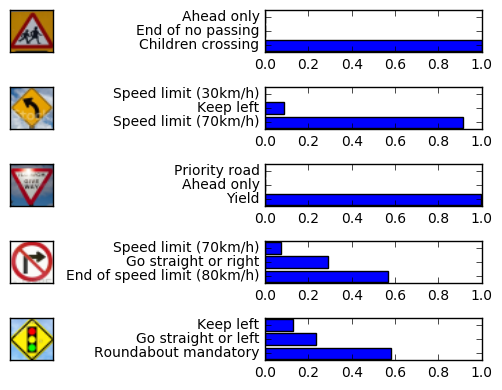

In [28]:
# plot visualization of softmax probabilities
index = np.arange(3)
probabilities, predict_classes = test_prediction

candidates = [5,6,8,1,14]
for i,im in enumerate(candidates):

    plt.subplot(5,2,(i+1)*2-1)
    plt.imshow(disp_imgs[im])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

    plt.subplot(5,2,(i+1)*2)
    plt.barh(index, probabilities[im], align='center')
    plt.yticks(index,[class_names[str(predict_classes[im][i])] for i in index] )
    plt.axis([0,1,-0.5,2.5])

    plt.tight_layout()